In [1]:
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random
import math
from skimage.io import imread
from skimage.transform import resize
from PIL import Image
import os

os.environ["KERAS_BACKEND"] = "jax"  # or tensorflow, or torch

import keras
import keras_hub
from keras.utils import PyDataset

2025-11-04 10:17:36.451017: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1762247856.462423   67474 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1762247856.466010   67474 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1762247856.475995   67474 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1762247856.476008   67474 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1762247856.476009   67474 computation_placer.cc:177] computation placer alr

In [2]:
label_map = {"Contradictory": 0, "Implies": 1, "NoEntailment": 2}

In [3]:
image_base_path = keras.utils.get_file(
    "tweet_images",
    "https://github.com/sayakpaul/Multimodal-Entailment-Baseline/releases/download/v1.0.0/tweet_images.tar.gz",
    untar=True,
)

344273442/344273442 ━━━━━━━━━━━━━━━━━━━━ 11s 0us/step


In [4]:
df = pd.read_csv(
    "https://github.com/sayakpaul/Multimodal-Entailment-Baseline/raw/main/csvs/tweets.csv"
).iloc[
    0:1000
]  # Resources conservation since these are examples and not SOTA
df.sample(10)

,id_1,text_1,image_1,id_2,text_2,image_2,label
559,1356422647605772288,1023 DAYTON ST https://t.co/SSKALaCw1A,http://pbs.twimg.com/media/EtL6txFWQAElOdd.jpg,1366731588491476992,1122 DAYTON ST https://t.co/8bXkf0IZew,http://pbs.twimg.com/media/EveJseUWYAAnCJo.jpg,NoEntailment
428,1360647374247391234,Knights Basketball GAMEDAY vs. Winslow! Go Kni...,http://pbs.twimg.com/media/EuHkd96XEAoLnYB.jpg,1364243635290701833,Our Knights Basketball Team hosts Globe tonigh...,http://pbs.twimg.com/media/Eu7EWx6XcAYf-Q0.jpg,NoEntailment
517,1372065159053774850,Pick up a copy of this week's #Bracknell News ...,http://pbs.twimg.com/media/Ewnhub4WgAge84-.jpg,1378935431664869377,Pick up a copy of this week's Bracknell News f...,http://pbs.twimg.com/media/EyJGf7wWQAA9dv2.jpg,NoEntailment
729,1359278474817658881,The OliveMan is green! Username checks out\n\n...,http://pbs.twimg.com/media/Et0gkb1XMAE_a4-.jpg,1366525254034722820,What a great day for our members!\n\nCheck our...,http://pbs.twimg.com/media/EvbfehKXEAcnWm_.png,NoEntailment
356,1359176302343946240,Crash Bandicoot 4 set to launch on Switch in M...,http://pbs.twimg.com/media/EtzDjvrXUAQtkzu.jpg,1359283014790832128,It's about time: Crash Bandicoot 4 comes to Sw...,http://pbs.twimg.com/media/Ety-a5kXUAIvUFf.jpg,NoEntailment
976,1354386596020121606,"15:30,27th Jan,Islamabad\n#PSX Closing Summary...",http://pbs.twimg.com/media/Esu_X7qUYAI2MDK.jpg,1382978279158677505,"13:00,Apr.16th,Islamabad\n#PSX Closing Summary...",http://pbs.twimg.com/media/EzFTaSzVkAYWHZG.jpg,NoEntailment
436,1379823441017253896,[Today Match Prediction] POT vs CHE Dream11 Fa...,http://pbs.twimg.com/media/EyYeG6aWgAMdFW3.jpg,1381997797424173057,[Today Match Prediction] CHE vs POT Dream11 Fa...,http://pbs.twimg.com/media/Ey3XrG8XAAED6ir.jpg,NoEntailment
120,1368969573291196416,FAST FORECAST: Here's a check of your lunchtim...,http://pbs.twimg.com/media/Ev-OjyqWgAYxbKZ.jpg,1376277718631858178,FAST FORECAST: Here's a check of your afternoo...,http://pbs.twimg.com/media/ExmFR9YWYAELFz9.jpg,NoEntailment
561,1347333465759485955,"Marketcap Winner $DIME, Marketcap Loser $VTC, ...",http://pbs.twimg.com/media/ErKwpXvXMAIkdk2.png,1374512555431927817,"Marketcap Winner $BAY, Marketcap Loser $XBY, B...",http://pbs.twimg.com/media/ExM_4kXVIAAUMXO.png,NoEntailment
527,1378494309842874369,"Friends, interested all go to have a look!\n@f...",http://pbs.twimg.com/media/EyFlRRUUYAEanqr.jpg,1381068163392004099,Friends! Anyone interested? Go and have a look...,http://pbs.twimg.com/media/EyqKLQSVEAMBO3C.jpg,Contradictory


In [5]:
images_one_paths = []
images_two_paths = []

for idx in range(len(df)):
    current_row = df.iloc[idx]
    id_1 = current_row["id_1"]
    id_2 = current_row["id_2"]
    extentsion_one = current_row["image_1"].split(".")[-1]
    extentsion_two = current_row["image_2"].split(".")[-1]

    image_one_path = os.path.join(image_base_path, str(id_1) + f".{extentsion_one}")
    image_two_path = os.path.join(image_base_path, str(id_2) + f".{extentsion_two}")

    images_one_paths.append(image_one_path)
    images_two_paths.append(image_two_path)

df["image_1_path"] = images_one_paths
df["image_2_path"] = images_two_paths

# Create another column containing the integer ids of
# the string labels.
df["label_idx"] = df["label"].apply(lambda x: label_map[x])

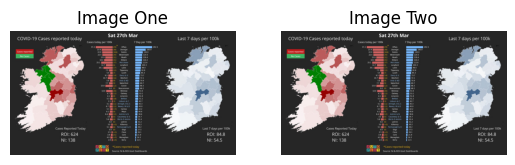

Text one: COVID-19 cases reported today:
     ️➡️ROI: 624
     ️➡️NI: 138 https://t.co/rmipiC9YG4
Text two: Mon 12th Apr - COVID-19 cases reported today:
     ️➡️ROI: 394
     ️➡️NI: 97 https://t.co/dZyOtvJBac
Label: NoEntailment


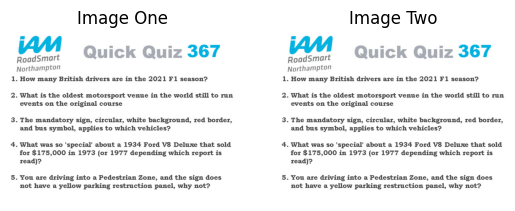

Text one: Here is our 367th general motoring quiz - unlike yesterday, we are not publishing the answers first 😅😂🤣
#LockdownQuiz
@IAMRoadSmart https://t.co/UIWYilD2vm
Text two: and today's 375th general motoring quiz is here!  Have fun!
#LockdownQuiz
#HighwayCode
@IAMRoadSmart https://t.co/omwZ7D6y7H
Label: NoEntailment


In [6]:
def visualize(idx):
    current_row = df.iloc[idx]
    image_1 = plt.imread(current_row["image_1_path"])
    image_2 = plt.imread(current_row["image_2_path"])
    text_1 = current_row["text_1"]
    text_2 = current_row["text_2"]
    label = current_row["label"]

    plt.subplot(1, 2, 1)
    plt.imshow(image_1)
    plt.axis("off")
    plt.title("Image One")
    plt.subplot(1, 2, 2)
    plt.imshow(image_1)
    plt.axis("off")
    plt.title("Image Two")
    plt.show()

    print(f"Text one: {text_1}")
    print(f"Text two: {text_2}")
    print(f"Label: {label}")


random_idx = random.choice(range(len(df)))
visualize(random_idx)

random_idx = random.choice(range(len(df)))
visualize(random_idx)

In [7]:
df["label"].value_counts()

label
NoEntailment     819
Contradictory     92
Implies           89
Name: count, dtype: int64

In [8]:
# 10% for test
train_df, test_df = train_test_split(
    df, test_size=0.1, stratify=df["label"].values, random_state=42
)
# 5% for validation
train_df, val_df = train_test_split(
    train_df, test_size=0.05, stratify=train_df["label"].values, random_state=42
)

print(f"Total training examples: {len(train_df)}")
print(f"Total validation examples: {len(val_df)}")
print(f"Total test examples: {len(test_df)}")

Total training examples: 855
Total validation examples: 45
Total test examples: 100


In [9]:
text_preprocessor = keras_hub.models.BertTextClassifierPreprocessor.from_preset(
    "bert_base_en_uncased",
    sequence_length=128,
)

2025-11-04 10:17:57.610977: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:47] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
I0000 00:00:1762247877.611735   67474 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 8890 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:08:00.0, compute capability: 7.5


In [10]:
idx = random.choice(range(len(train_df)))
row = train_df.iloc[idx]
sample_text_1, sample_text_2 = row["text_1"], row["text_2"]
print(f"Text 1: {sample_text_1}")
print(f"Text 2: {sample_text_2}")

test_text = [sample_text_1, sample_text_2]
text_preprocessed = text_preprocessor(test_text)

print("Keys           : ", list(text_preprocessed.keys()))
print("Shape Token Ids : ", text_preprocessed["token_ids"].shape)
print("Token Ids       : ", text_preprocessed["token_ids"][0, :16])
print(" Shape Padding Mask     : ", text_preprocessed["padding_mask"].shape)
print("Padding Mask     : ", text_preprocessed["padding_mask"][0, :16])
print("Shape Segment Ids : ", text_preprocessed["segment_ids"].shape)
print("Segment Ids       : ", text_preprocessed["segment_ids"][0, :16])

Text 1: I don't know who need this, but here's a baby Toucan. https://t.co/xgFP1OSyEF
Text 2: @veefroggy Want a baby tucan? https://t.co/WnkPaxFlu6
Keys           :  ['token_ids', 'padding_mask', 'segment_ids']
Shape Token Ids :  (2, 128)
Token Ids       :  [ 101 1045 2123 1005 1056 2113 2040 2342 2023 1010 2021 2182 1005 1055
 1037 3336]
 Shape Padding Mask     :  (2, 128)
Padding Mask     :  [ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True]
Shape Segment Ids :  (2, 128)
Segment Ids       :  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [11]:
def dataframe_to_dataset(dataframe):
    columns = ["image_1_path", "image_2_path", "text_1", "text_2", "label_idx"]
    ds = UnifiedPyDataset(
        dataframe,
        batch_size=32,
        workers=4,
    )
    return ds

In [12]:
bert_input_features = ["padding_mask", "segment_ids", "token_ids"]


def preprocess_text(text_1, text_2):
    output = text_preprocessor([text_1, text_2])
    output = {
        feature: keras.ops.reshape(output[feature], [-1])
        for feature in bert_input_features
    }
    return output

In [13]:
class UnifiedPyDataset(PyDataset):
    """A Keras-compatible dataset that processes a DataFrame for TensorFlow, JAX, and PyTorch."""

    def __init__(
        self,
        df,
        batch_size=32,
        workers=4,
        use_multiprocessing=False,
        max_queue_size=10,
        **kwargs,
    ):
        """
        Args:
            df: pandas DataFrame with data
            batch_size: Batch size for dataset
            workers: Number of workers to use for parallel loading (Keras)
            use_multiprocessing: Whether to use multiprocessing
            max_queue_size: Maximum size of the data queue for parallel loading
        """
        super().__init__(**kwargs)
        self.dataframe = df
        columns = ["image_1_path", "image_2_path", "text_1", "text_2"]

        # image files
        self.image_x_1 = self.dataframe["image_1_path"]
        self.image_x_2 = self.dataframe["image_1_path"]
        self.image_y = self.dataframe["label_idx"]

        # text files
        self.text_x_1 = self.dataframe["text_1"]
        self.text_x_2 = self.dataframe["text_2"]
        self.text_y = self.dataframe["label_idx"]

        # general
        self.batch_size = batch_size
        self.workers = workers
        self.use_multiprocessing = use_multiprocessing
        self.max_queue_size = max_queue_size

    def __getitem__(self, index):
        """
        Fetches a batch of data from the dataset at the given index.
        """

        # Return x, y for batch idx.
        low = index * self.batch_size
        # Cap upper bound at array length; the last batch may be smaller
        # if the total number of items is not a multiple of batch size.

        high_image_1 = min(low + self.batch_size, len(self.image_x_1))
        high_image_2 = min(low + self.batch_size, len(self.image_x_2))

        high_text_1 = min(low + self.batch_size, len(self.text_x_1))
        high_text_2 = min(low + self.batch_size, len(self.text_x_1))

        # images files
        batch_image_x_1 = self.image_x_1[low:high_image_1]
        batch_image_y_1 = self.image_y[low:high_image_1]

        batch_image_x_2 = self.image_x_2[low:high_image_2]
        batch_image_y_2 = self.image_y[low:high_image_2]

        # text files
        batch_text_x_1 = self.text_x_1[low:high_text_1]
        batch_text_y_1 = self.text_y[low:high_text_1]

        batch_text_x_2 = self.text_x_2[low:high_text_2]
        batch_text_y_2 = self.text_y[low:high_text_2]

        # image number 1 inputs
        image_1 = [
            resize(imread(file_name), (128, 128)) for file_name in batch_image_x_1
        ]
        image_1 = [
            (  # exeperienced some shapes which were different from others.
                np.array(Image.fromarray((img.astype(np.uint8))).convert("RGB"))
                if img.shape[2] == 4
                else img
            )
            for img in image_1
        ]
        image_1 = np.array(image_1)

        # Both text inputs to the model, return a dict for inputs to BertBackbone
        text = {
            key: np.array(
                [
                    d[key]
                    for d in [
                        preprocess_text(file_path1, file_path2)
                        for file_path1, file_path2 in zip(
                            batch_text_x_1, batch_text_x_2
                        )
                    ]
                ]
            )
            for key in ["padding_mask", "token_ids", "segment_ids"]
        }

        # Image number 2 model inputs
        image_2 = [
            resize(imread(file_name), (128, 128)) for file_name in batch_image_x_2
        ]
        image_2 = [
            (  # exeperienced some shapes which were different from others
                np.array(Image.fromarray((img.astype(np.uint8))).convert("RGB"))
                if img.shape[2] == 4
                else img
            )
            for img in image_2
        ]
        # Stack the list comprehension to an nd.array
        image_2 = np.array(image_2)

        return (
            {
                "image_1": image_1,
                "image_2": image_2,
                "padding_mask": text["padding_mask"],
                "segment_ids": text["segment_ids"],
                "token_ids": text["token_ids"],
            },
            # Target lables
            np.array(batch_image_y_1),
        )

    def __len__(self):
        """
        Returns the number of batches in the dataset.
        """
        return math.ceil(len(self.dataframe) / self.batch_size)

In [14]:
def prepare_dataset(dataframe):
    ds = dataframe_to_dataset(dataframe)
    return ds


train_ds = prepare_dataset(train_df)
validation_ds = prepare_dataset(val_df)
test_ds = prepare_dataset(test_df)

In [15]:
def project_embeddings(
    embeddings, num_projection_layers, projection_dims, dropout_rate
):
    projected_embeddings = keras.layers.Dense(units=projection_dims)(embeddings)
    for _ in range(num_projection_layers):
        x = keras.ops.nn.gelu(projected_embeddings)
        x = keras.layers.Dense(projection_dims)(x)
        x = keras.layers.Dropout(dropout_rate)(x)
        x = keras.layers.Add()([projected_embeddings, x])
        projected_embeddings = keras.layers.LayerNormalization()(x)
    return projected_embeddings

In [16]:
def create_vision_encoder(
    num_projection_layers, projection_dims, dropout_rate, trainable=False
):
    # Load the pre-trained ResNet50V2 model to be used as the base encoder.
    resnet_v2 = keras.applications.ResNet50V2(
        include_top=False, weights="imagenet", pooling="avg"
    )
    # Set the trainability of the base encoder.
    for layer in resnet_v2.layers:
        layer.trainable = trainable

    # Receive the images as inputs.
    image_1 = keras.Input(shape=(128, 128, 3), name="image_1")
    image_2 = keras.Input(shape=(128, 128, 3), name="image_2")

    # Preprocess the input image.
    preprocessed_1 = keras.applications.resnet_v2.preprocess_input(image_1)
    preprocessed_2 = keras.applications.resnet_v2.preprocess_input(image_2)

    # Generate the embeddings for the images using the resnet_v2 model
    # concatenate them.
    embeddings_1 = resnet_v2(preprocessed_1)
    embeddings_2 = resnet_v2(preprocessed_2)
    embeddings = keras.layers.Concatenate()([embeddings_1, embeddings_2])

    # Project the embeddings produced by the model.
    outputs = project_embeddings(
        embeddings, num_projection_layers, projection_dims, dropout_rate
    )
    # Create the vision encoder model.
    return keras.Model([image_1, image_2], outputs, name="vision_encoder")

In [17]:
def create_text_encoder(
    num_projection_layers, projection_dims, dropout_rate, trainable=False
):
    # Load the pre-trained BERT BackBone using KerasHub.
    bert = keras_hub.models.BertBackbone.from_preset(
        "bert_base_en_uncased", num_classes=3
    )

    # Set the trainability of the base encoder.
    bert.trainable = trainable

    # Receive the text as inputs.
    bert_input_features = ["padding_mask", "segment_ids", "token_ids"]
    inputs = {
        feature: keras.Input(shape=(256,), dtype="int32", name=feature)
        for feature in bert_input_features
    }

    # Generate embeddings for the preprocessed text using the BERT model.
    embeddings = bert(inputs)["pooled_output"]

    # Project the embeddings produced by the model.
    outputs = project_embeddings(
        embeddings, num_projection_layers, projection_dims, dropout_rate
    )
    # Create the text encoder model.
    return keras.Model(inputs, outputs, name="text_encoder")

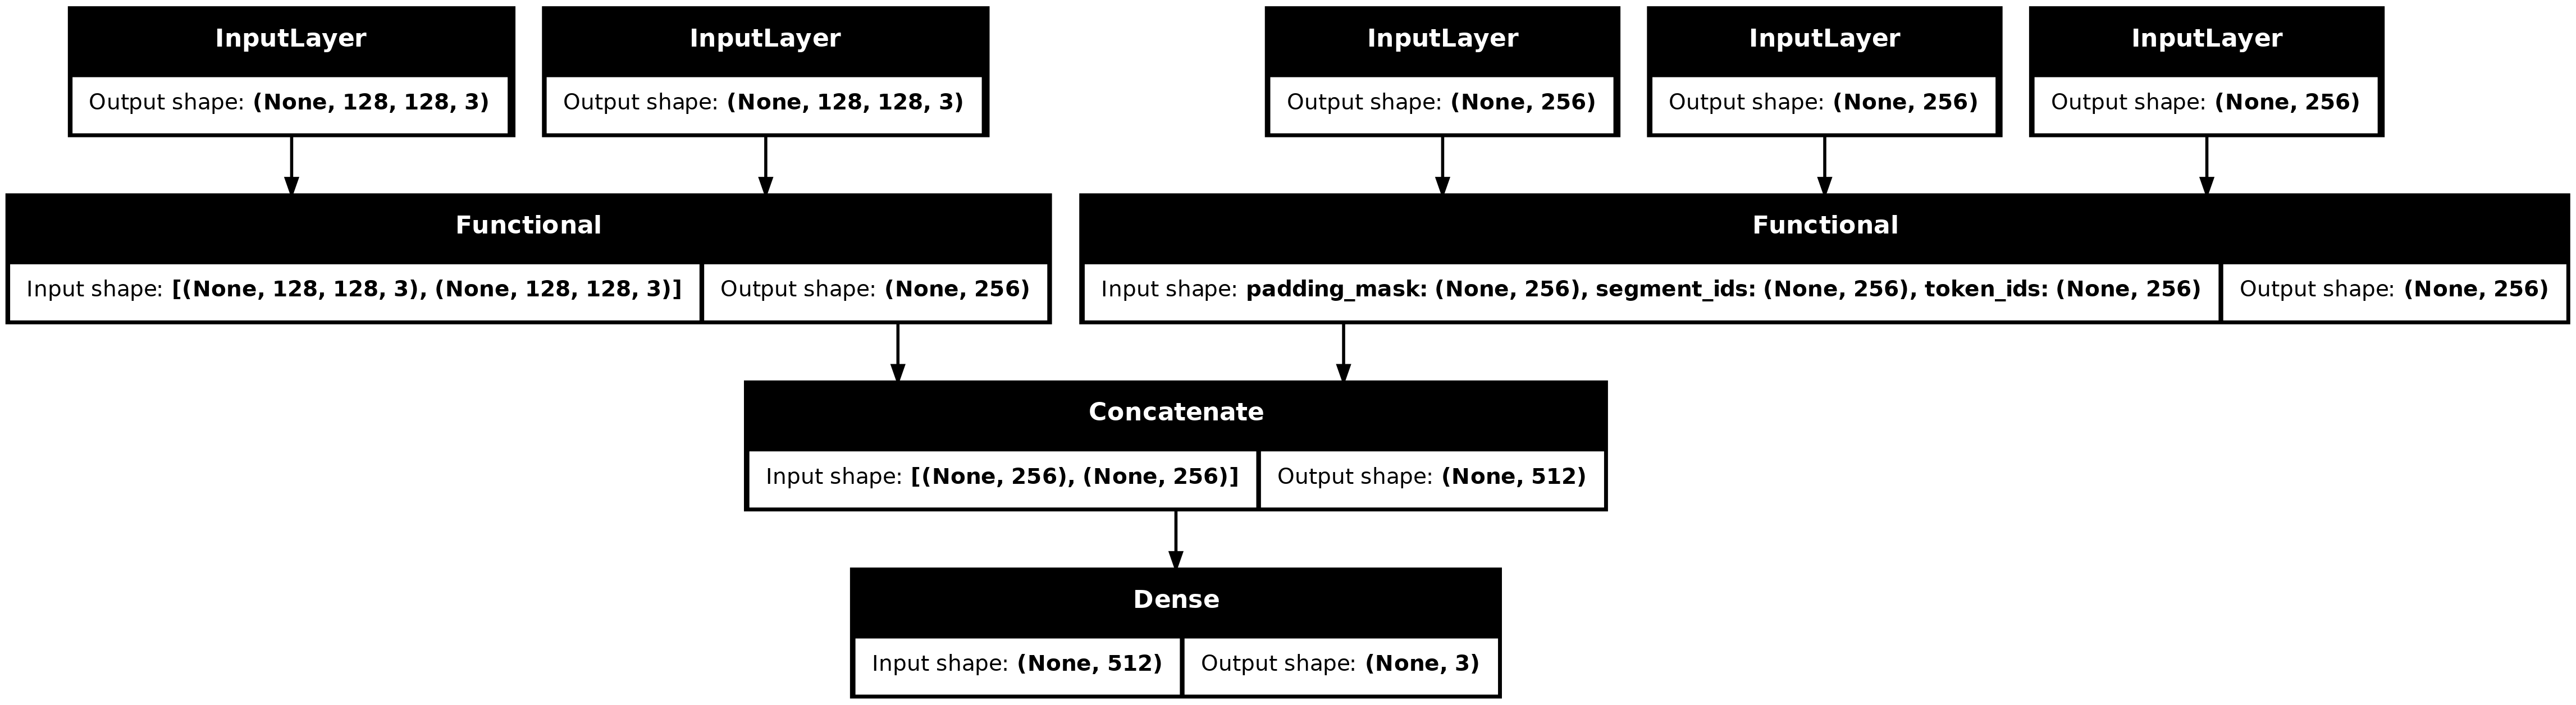

In [18]:
def create_multimodal_model(
    num_projection_layers=1,
    projection_dims=256,
    dropout_rate=0.1,
    vision_trainable=False,
    text_trainable=False,
):
    # Receive the images as inputs.
    image_1 = keras.Input(shape=(128, 128, 3), name="image_1")
    image_2 = keras.Input(shape=(128, 128, 3), name="image_2")

    # Receive the text as inputs.
    bert_input_features = ["padding_mask", "segment_ids", "token_ids"]
    text_inputs = {
        feature: keras.Input(shape=(256,), dtype="int32", name=feature)
        for feature in bert_input_features
    }
    text_inputs = list(text_inputs.values())
    # Create the encoders.
    vision_encoder = create_vision_encoder(
        num_projection_layers, projection_dims, dropout_rate, vision_trainable
    )
    text_encoder = create_text_encoder(
        num_projection_layers, projection_dims, dropout_rate, text_trainable
    )

    # Fetch the embedding projections.
    vision_projections = vision_encoder([image_1, image_2])
    text_projections = text_encoder(text_inputs)

    # Concatenate the projections and pass through the classification layer.
    concatenated = keras.layers.Concatenate()([vision_projections, text_projections])
    outputs = keras.layers.Dense(3, activation="softmax")(concatenated)
    return keras.Model([image_1, image_2, *text_inputs], outputs)


multimodal_model = create_multimodal_model()
keras.utils.plot_model(multimodal_model, show_shapes=True)

In [19]:
multimodal_model.compile(
    optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"]
)

history = multimodal_model.fit(train_ds, validation_data=validation_ds, epochs=1)

/home/xy/Desktop/ml/legacy/legacy/lib/python3.10/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: {'padding_mask': 'padding_mask', 'segment_ids': 'segment_ids', 'token_ids': 'token_ids'}
Received: inputs=['Tensor(shape=(32, 256))', 'Tensor(shape=(32, 256))', 'Tensor(shape=(32, 256))']
  warnings.warn(msg)
/home/xy/Desktop/ml/legacy/legacy/lib/python3.10/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: {'padding_mask': 'padding_mask', 'segment_ids': 'segment_ids', 'token_ids': 'token_ids'}
Received: inputs=['Tensor(shape=(32, 256))', 'Tensor(shape=(32, 256))', 'Tensor(shape=(32, 256))']
  warnings.warn(msg)


27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6747 - loss: 1.9323

/home/xy/Desktop/ml/legacy/legacy/lib/python3.10/site-packages/PIL/Image.py:1039: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/xy/Desktop/ml/legacy/legacy/lib/python3.10/site-packages/PIL/Image.py:1039: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/xy/Desktop/ml/legacy/legacy/lib/python3.10/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: {'padding_mask': 'padding_mask', 'segment_ids': 'segment_ids', 'token_ids': 'token_ids'}
Received: inputs=['Tensor(shape=(32, 256))', 'Tensor(shape=(32, 256))', 'Tensor(shape=(32, 256))']
  warnings.warn(msg)
/home/xy/Desktop/ml/legacy/legacy/lib/python3.10/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: {'padding_mask': 'pad

27/27 ━━━━━━━━━━━━━━━━━━━━ 75s 3s/step - accuracy: 0.7766 - loss: 1.7422 - val_accuracy: 0.8222 - val_loss: 1.7480


In [20]:
_, acc = multimodal_model.evaluate(test_ds)
print(f"Accuracy on the test set: {round(acc * 100, 2)}%.")

/home/xy/Desktop/ml/legacy/legacy/lib/python3.10/site-packages/PIL/Image.py:1039: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/xy/Desktop/ml/legacy/legacy/lib/python3.10/site-packages/PIL/Image.py:1039: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


1/4 ━━━━━━━━━━━━━━━━━━━━ 25s 8s/step - accuracy: 0.8073 - loss: 1.8272

/home/xy/Desktop/ml/legacy/legacy/lib/python3.10/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: {'padding_mask': 'padding_mask', 'segment_ids': 'segment_ids', 'token_ids': 'token_ids'}
Received: inputs=['Tensor(shape=(4, 256))', 'Tensor(shape=(4, 256))', 'Tensor(shape=(4, 256))']
  warnings.warn(msg)


4/4 ━━━━━━━━━━━━━━━━━━━━ 11s 955ms/step - accuracy: 0.8200 - loss: 1.6769
Accuracy on the test set: 82.0%.
